# Notebook_005_orbitpropa_sgp4_local_topo_visualization.ipynb

# Demonstrate orbit propagation (OP) using the SGP4 method

# Plot the ground track

# Transform the trajectory into the local (topocentric) frame

Example: ISS TLE file downloaded from celestrak.com on 22 August 2017 at 04:40 UTC.

ISS (ZARYA)                         
1 25544U 98067A   17233.89654113  .00001846  00000-0  35084-4 0  9996

2 25544  51.6406  70.7550 0005080 161.3029 292.5190 15.54181235 71970

The local frame is centered on the ground station.

Ground station: Cape Town
(33.9249 deg S, 18.4241 deg E)

@author: Ashiv Dhondea

Created on 22 August 2017

Our work is based on the theory, standards and conventions adopted in the book "Fundamentals of Astrodynamics" (2013) by David Vallado.

We employ the WGS84 geodetic standard.

The ECI (Earth-Centered Inertial), ECEF (Earth-Centered, Earth-Fixed) and SEZ (South-East-Zenith) frames are defined in the book cited.


The figure below shows a space object (SO) in orbit around the Earth.

The ECEF and SEZ frames are defined in the figure below. 

The label 'Rx' denotes the receiver in a radar system. Here it denotes the location of the ground station on the surface of the Earth.

The longitude $\lambda$ and geocentric latitude $\phi_\text{gc}$ define the location of a point on the surface of the WGS84 oblate spheroid.

The geocentric latitude $\phi_\text{gc}$ is calculated from the geodetic latitude $\phi_\text{gd}$ which is usually quoted online (Google Earth, heavens-above etc.)

In radar coordinates, aka spherical coordinates, the position of the SO with respect to the radar is expressed as $(\rho,\theta,\psi)$. The slant-range from the observer to the target is denoted by $\rho$ while the look angles, i.e., the elevation angle and azimuth angle are denoted by $\theta$ and $\psi$, respectively.

It is extremely important to take note of how these two angles are defined. Different authors in different fields employ different definitions for the look angles. The azimuth angle $\psi$ is measured from the positive $x$-axis to the positive $y$-axis in this project. Vallado (2013) defines his azimuth angle from the negative $x$-axis to the positive $y$-axis.

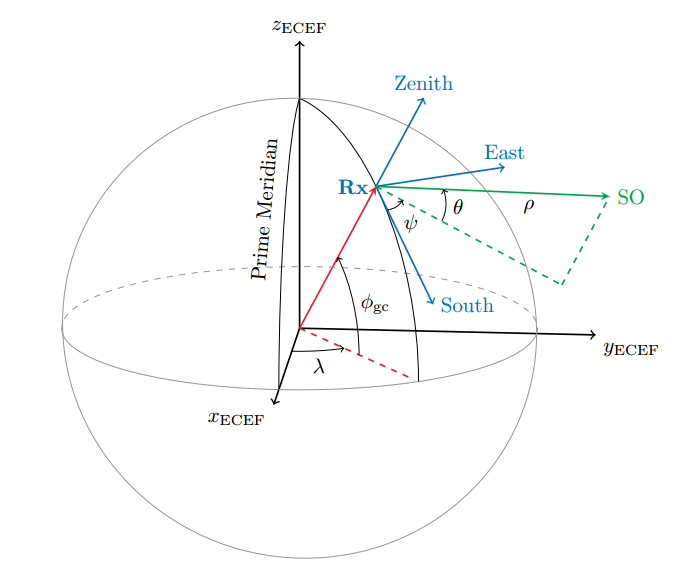

In [1]:
from IPython.display import Image
Image(filename='ashivorbit2017.png')
# Note that this image belongs to me. I have created it myself.

In [2]:
# Load the libraries required
# These two are mine
import AstroFunctions as AstFn
import UnbiasedConvertedMeasurements as UCM

import math
import numpy as np

# Libraries needed for time keeping and formatting
import datetime as dt
import pytz

# Importing what's needed for nice plots.
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# Module for SGP4 orbit propagation
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv

The observer or ground station is identified by its latitude, longitude and height above the Mean Sea Level (MSL).

We have assumed that the ground station is at sea level below.

In [3]:
# Location of observer [Cape Town, ZA]
lat_station = -33.9249; # [deg]
lon_station =  18.4241; # [deg]
altitude_station = 0; # [m]

The Two Line Element (TLE) data for the Internation Space Station is obtained from celestrak.com.

We want to use a recent TLE set to avoid inaccurate orbit propagation results caused by outdated initial values.

In [4]:
## ISS (ZARYA)                        
tle_line1 = '1 25544U 98067A   17233.89654113  .00001846  00000-0  35084-4 0  9996';
tle_line2 = '2 25544  51.6406  70.7550 0005080 161.3029 292.5190 15.54181235 71970';
so_name = 'ISS (ZARYA)'
# Read TLE to extract Keplerians and epoch. 
a,e,i,BigOmega,omega,E,nu,epoch  = AstFn.fnTLEtoKeps(tle_line1,tle_line2);

# Create satellite object
satellite_obj = twoline2rv(tle_line1, tle_line2, wgs84);

line1 = (tle_line1);
line2 = (tle_line2);

In [5]:
# Figure out the TLE epoch 
year,dayy, hrs, mins, secs, millisecs = AstFn.fn_Calculate_Epoch_Time(epoch);
todays_date = AstFn.fn_epoch_date(year,dayy);
print "TLE epoch date is", todays_date
print "UTC time = ",hrs,"h",mins,"min",secs+millisecs,"s"
timestamp_tle_epoch = dt.datetime(year=todays_date.year,month=todays_date.month,day=todays_date.day,hour=hrs,minute=mins,second=secs,microsecond=int(millisecs),tzinfo= pytz.utc);


TLE epoch date is 2017-08-21
UTC time =  21 h 31 min 1.153632 s


According to heavens-above.com, the ISS will be visible in Cape Town (SA) from 05:07:50 to 05:08:38 (local time).

The local time (SAST) is 2 hours ahead of UTC.
So the observation epoch is 03:07:50 to 03:08:38

In [6]:
# Find start and end of observation window.
# Find the time elapsed between the epoch of the TLE and the start and end of the observation window
observation_epoch= dt.datetime(year=todays_date.year,month=todays_date.month,day=22,hour=3,minute=8,second=38,microsecond=0,tzinfo= pytz.utc);
simulation_duration_dt_obj = observation_epoch - timestamp_tle_epoch;
simulation_duration_secs = simulation_duration_dt_obj.total_seconds();

start_observation_epoch = dt.datetime(year=todays_date.year,month=todays_date.month,day=22,hour=3,minute=7,second=50,microsecond=0,tzinfo= pytz.utc)
start_simulation_duration_dt_obj = start_observation_epoch - timestamp_tle_epoch;
start_simulation_duration_secs = start_simulation_duration_dt_obj.total_seconds()

The time step used in orbit propagation does influence the accuracy of the OP results. However, we do not want to worry about this too much.

For most applications, a time step of 1 second for a simulation lasting less than 24 hours should be reasonably fine.

In [7]:
# Declare time and state vector variables.
delta_t = 1; #[s]
print 'Propagation time step = %d' %delta_t, '[s]'
duration = simulation_duration_secs; #[s]
print 'Duration of simulation = %d' %duration, '[s]'
timevec = np.arange(0,duration+delta_t,delta_t,dtype=np.float64);
x_state_sgp4 = np.zeros([6,len(timevec)],dtype=np.float64);
xecef_sgp4 = np.zeros([3,len(timevec)],dtype=np.float64);
# Declare variables to store latitude and longitude values of the ground track
lat_sgp4 = np.zeros([len(timevec)],dtype=np.float64);
lon_sgp4 = np.zeros([len(timevec)],dtype=np.float64);

Propagation time step = 1 [s]
Duration of simulation = 20257 [s]


In [8]:
# Identify the indices corresponding to start and end of the observation window
obsv_window_start_index = int(start_simulation_duration_secs/delta_t)
obsv_window_end_index = len(timevec) - 1;
print 'observation window starts at index '
print obsv_window_start_index
print 'and ends at '
print obsv_window_end_index
obsv_window_duration = (obsv_window_end_index - obsv_window_start_index);# should be int, not float
print 'Duration of observation window in [min]'
print obsv_window_duration*delta_t/60
obsv_window_timestamps = [None]*(obsv_window_duration+1); # Initialize empty list to hold time stamps
print 'Number of data points in observation window: '
print len(obsv_window_timestamps)

observation window starts at index 
20209
and ends at 
20257
Duration of observation window in [min]
0
Number of data points in observation window: 
49


Perform Orbit Propagation (OP) by calling an SGP4 method. 

In [9]:
R_SEZ = np.zeros([3,len(timevec)],dtype=np.float64);
V_SEZ = np.zeros([3,len(timevec)],dtype=np.float64);
x_target = np.zeros([6,len(timevec)],dtype=np.float64); 
#  spherical measurements from the Rx
y_sph_rx = np.zeros([3,len(timevec)],dtype=np.float64);

index = 0;
current_time = timevec[index];
hrs,mins,secs = AstFn.fnSeconds_To_Hours(current_time + (satellite_obj.epoch.hour*60*60) + (satellite_obj.epoch.minute*60)+ satellite_obj.epoch.second);
dys = satellite_obj.epoch.day + int(math.ceil(hrs/24));     
if hrs >= 24:
    hrs = hrs - 24*int(math.ceil(hrs/24)) ;
satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
x_state_sgp4[0:3,index] = np.asarray(satpos);
x_state_sgp4[3:6,index] = np.asarray(satvel);

theta_GMST =  math.radians(AstFn.fn_Convert_Datetime_to_GMST(timestamp_tle_epoch));        
# Rotate ECI position vector by GMST angle to get ECEF position
theta_GMST = AstFn.fnZeroTo2Pi(theta_GMST);
xecef_sgp4[:,index] = AstFn.fnECItoECEF(x_state_sgp4[0:3,index],theta_GMST);
lat_sgp4[index],lon_sgp4[index] = AstFn.fnCarts_to_LatLon(xecef_sgp4[:,index]);

for index in range(1,len(timevec)):
    # Find the current time
    current_time = timevec[index];
    hrs,mins,secs = AstFn.fnSeconds_To_Hours(current_time + (timestamp_tle_epoch.hour*60*60) + (timestamp_tle_epoch.minute*60)+ timestamp_tle_epoch.second);
    dys = timestamp_tle_epoch.day + int(math.ceil(hrs/24)); 
    if hrs >= 24:
        hrs = hrs - 24*int(math.ceil(hrs/24)) ;
        
    # SGP4 propagation
    satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
    x_state_sgp4[0:3,index] = np.asarray(satpos);
    x_state_sgp4[3:6,index] = np.asarray(satvel);
    
    # From the epoch, find the GMST angle.
    tle_epoch_test = dt.datetime(year=timestamp_tle_epoch.year,month=timestamp_tle_epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
    theta_GMST =  math.radians(AstFn.fn_Convert_Datetime_to_GMST(tle_epoch_test));        
    # Rotate ECI position vector by GMST angle to get ECEF position
    theta_GMST = AstFn.fnZeroTo2Pi(theta_GMST);
    xecef_sgp4[:,index] = AstFn.fnECItoECEF(x_state_sgp4[0:3,index],theta_GMST);
    lat_sgp4[index],lon_sgp4[index] = AstFn.fnCarts_to_LatLon(xecef_sgp4[:,index]);
    if index >= obsv_window_start_index:
        # We store away timestamps for the observation window
        current_time_iso = tle_epoch_test.isoformat() + 'Z'
        obsv_window_timestamps[index-obsv_window_start_index] =current_time_iso;
        
        # We find the position and velocity vector for the target in the local frame.
        # We then create the measurement vector consisting of range and look angles to the target.
        R_ECI = x_state_sgp4[0:3,index]; V_ECI = x_state_sgp4[3:6,index];  
        R_SEZ[:,index] = AstFn.fnRAZEL_Cartesian(math.radians(lat_station),math.radians(lon_station),altitude_station,R_ECI,theta_GMST); 
        R_ECEF = AstFn.fnECItoECEF(R_ECI,theta_GMST);
        V_SEZ[:,index] = AstFn.fnVel_ECI_to_SEZ(V_ECI,R_ECEF,math.radians(lat_station),math.radians(lon_station),theta_GMST);
        x_target[:,index] = np.hstack((R_SEZ[:,index],V_SEZ[:,index])); # state vector in SEZ frame
        # Calculate range and angles for system modelling.
        y_sph_rx[:,index] = UCM.fnCalculate_Spherical(R_SEZ[:,index]); # slant-range and look angles wrt to Rx
        

Plot the ground track. This is an equirectangular projection, by the way.

I have created this ground track plot from a MATLAB ground track plotter developed by a Mr. Richard Rieber, found [here](https://www.mathworks.com/matlabcentral/fileexchange/13439-orbital-mechanics-library?requestedDomain=www.mathworks.com) 

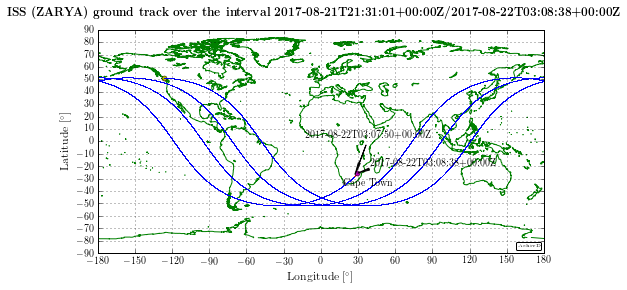

In [10]:
%matplotlib inline

title_string = str(timestamp_tle_epoch.isoformat())+ 'Z/'+str(obsv_window_timestamps[-1]);

coastline_data= np.loadtxt('Coastline.txt',skiprows=1)
w, h = plt.figaspect(0.5)
fig = plt.figure(figsize=(w,h))
ax = fig.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
params = {'legend.fontsize': 8,
    'legend.handlelength': 2}
plt.rcParams.update(params)

fig.suptitle(r"\textbf{%s ground track over the interval %s}" %(so_name,title_string),fontsize=12)
plt.plot(coastline_data[:,0],coastline_data[:,1],'g');
ax.set_xlabel(r'Longitude $[\mathrm{^\circ}]$',fontsize=12)
ax.set_ylabel(r'Latitude $[\mathrm{^\circ}]$',fontsize=12)
plt.xlim(-180,180);
plt.ylim(-90,90);
plt.yticks([-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90]);
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]);
plt.plot(math.degrees(lon_sgp4[0]),math.degrees(lat_sgp4[0]),'yo',markersize=5,label=timestamp_tle_epoch.isoformat() + 'Z');
for index in range(1,obsv_window_start_index-1):
    plt.plot(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index]),'b.',markersize=1);

plt.annotate(r'%s' %obsv_window_timestamps[0], xy=(math.degrees(lon_sgp4[index+1]),math.degrees(lat_sgp4[index+1])),  xycoords='data',
            xytext=(math.degrees(lon_sgp4[index+1])-40,math.degrees(lat_sgp4[index+1])+30),
            arrowprops=dict(facecolor='black',shrink=0.05,width=0.1,headwidth=2))

for index in range(obsv_window_start_index,obsv_window_end_index+1):
    plt.plot(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index]),color='crimson',marker='.',markersize=1);

plt.plot(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index]),'mo',markersize=5,label=current_time_iso);

plt.annotate(r'%s' %obsv_window_timestamps[obsv_window_duration], xy=(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index])),  xycoords='data',
            xytext=(math.degrees(lon_sgp4[index])+10,math.degrees(lat_sgp4[index])+5),
            arrowprops=dict(facecolor='black', shrink=0.05,width=0.1,headwidth=2)
            )

ax.grid(True);
plt.plot(lon_station,lat_station,marker='.',color='gray'); # station lat lon
ax.annotate(r'Cape Town', (18, -36));

at = AnchoredText("AshivD",prop=dict(size=5), frameon=True,loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
fig.savefig('notebook_005_orbitpropa_sgp4_local_topo_visualization_groundtrack.pdf',format='pdf',bbox_inches='tight',pad_inches=0.01,dpi=100);

Radar people usually only deal with targets moving in a local frame. This is where they do their target motion analysis, radar geometry analysis, radar system design and whatnot.

For a space object problem, we have to transform the scenario into the local/topocentric frame, which is shown below.

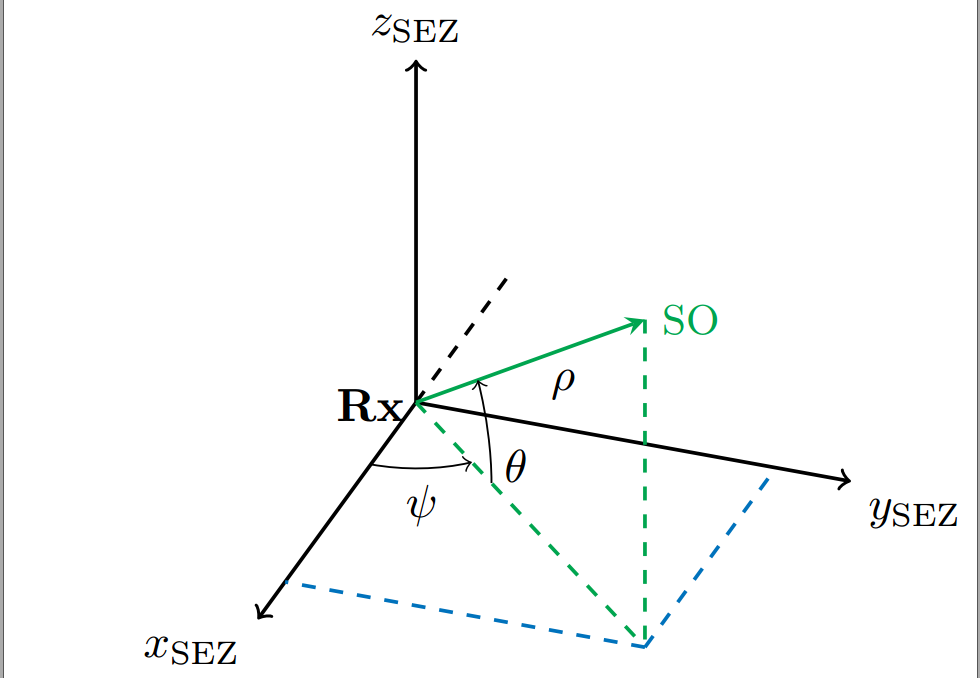

In [11]:
from IPython.display import Image
Image(filename='site_geometry_ashivd.png') 

People who merely want to catch a glimpse of the ISS and not worry about radar stuff, here's a quick explanation.

When you are standing outside, the horizontal plane with respect to your eyes is the $x-y$ plane labelled as $x_\text{SEZ}, y_\text{SEZ}$ in the figure above. $x$ points in the direction of the South and $y$, the East. Therefore $z$ is straight up skywards.   

The figure below shows the ISS's trajectory in the observer's frame.

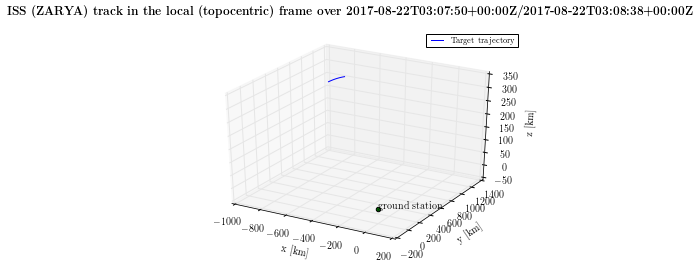

In [12]:
title_string_obsv = str(obsv_window_timestamps[0])+'/'+str(obsv_window_timestamps[-1]);

fig = plt.figure(2);
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
params = {'legend.fontsize': 8,
    'legend.handlelength': 2}
plt.rcParams.update(params);
ax = fig.gca(projection='3d');
plt.hold(True)
fig.suptitle(r"\textbf{%s track in the local (topocentric) frame over %s}" %(so_name,title_string_obsv),fontsize=12)

ax.plot(R_SEZ[0,obsv_window_start_index:obsv_window_end_index+1],R_SEZ[1,obsv_window_start_index:obsv_window_end_index+1],R_SEZ[2,obsv_window_start_index:obsv_window_end_index+1],label=r'Target trajectory');

ax.scatter(0,0,0,c='darkgreen',marker='o');
ax.text(0,0,0,r'ground station',color='k')

ax.legend();
ax.set_xlabel(r'x [$\mathrm{km}$]')
ax.set_ylabel(r'y [$\mathrm{km}$]')
ax.set_zlabel(r'z [$\mathrm{km}$]')
fig.savefig('notebook_005_orbitpropa_sgp4_local_topo_visualization_SEZtrack.pdf',format='pdf',bbox_inches='tight',pad_inches=0.08,dpi=100);

The figure shown below illustrates the 3 components of the radar vector during the ISS's passage.

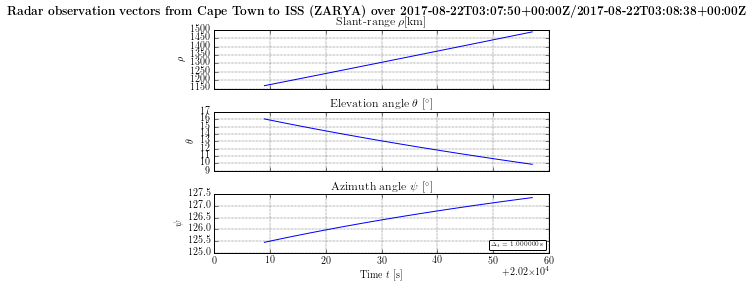

In [13]:
f, axarr = plt.subplots(3,sharex=True);
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
f.suptitle(r"\textbf{Radar observation vectors from Cape Town to %s over %s}" %(so_name,title_string_obsv),fontsize=12)
axarr[0].plot(timevec[obsv_window_start_index:obsv_window_end_index+1],y_sph_rx[0,obsv_window_start_index:obsv_window_end_index+1])
axarr[0].set_ylabel(r'$\rho$');
axarr[0].set_title(r'Slant-range $\rho [\mathrm{km}]$')
axarr[1].plot(timevec[obsv_window_start_index:obsv_window_end_index+1],np.degrees(y_sph_rx[1,obsv_window_start_index:obsv_window_end_index+1]))
axarr[1].set_title(r'Elevation angle $\theta~[\mathrm{^\circ}]$')
axarr[1].set_ylabel(r'$\theta$');

axarr[2].plot(timevec[obsv_window_start_index:obsv_window_end_index+1],np.degrees(y_sph_rx[2,obsv_window_start_index:obsv_window_end_index+1]))
axarr[2].set_title(r'Azimuth angle $\psi~[\mathrm{^\circ}]$')
axarr[2].set_ylabel(r'$ \psi$');
axarr[2].set_xlabel(r'Time $t~[\mathrm{s}$]');

axarr[0].grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')
axarr[1].grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')
axarr[2].grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')

at = AnchoredText(r"$\Delta_t = %f ~\mathrm{s}$" %delta_t,prop=dict(size=6), frameon=True,loc=4)
at.patch.set_boxstyle("round,pad=0.05,rounding_size=0.2")
axarr[2].add_artist(at)
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0:2]], visible=False)
plt.subplots_adjust(hspace=0.4)
f.savefig('notebook_005_orbitpropa_sgp4_local_topo_visualization_radarvec.pdf',bbox_inches='tight',pad_inches=0.05,dpi=100)  


The top plot shows the evolution of the slant-range to the target, $\rho$, over time. The middle plot shows that the elevation angle is about $16^\circ$ above the horizon at the beginning of the observation window. The target disappears at about $10^\circ$ above the horizon at the end of the observation window.

The target's azimuth angle is always about $120^\circ$, which is roughly in the direction of the North-East (NE), according to the azimuth angle defined in the previous figures.

These values match closely to the ones found on the [heavens-above page](http://heavens-above.com/PassSummary.aspx?satid=25544).

Here's a screenshot

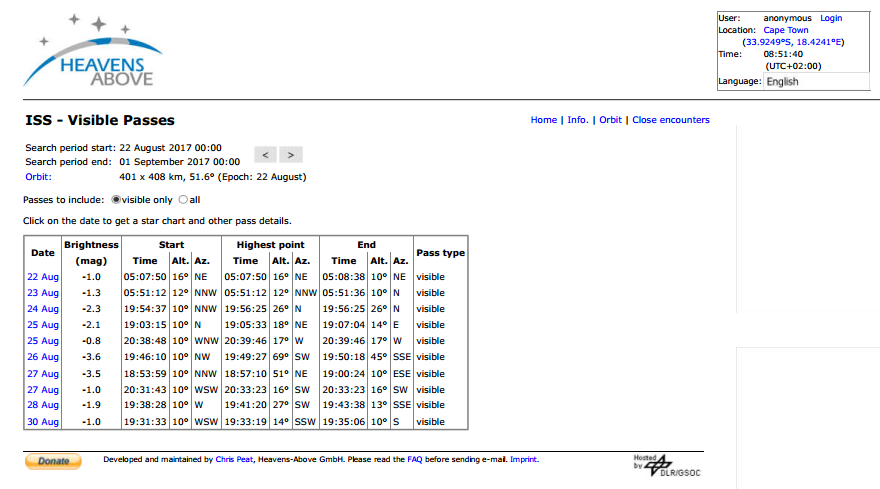

In [14]:
from IPython.display import Image
Image(filename='heavens_above_iss_passage.png')

The first visible pass in the table is the one we investigated.

The epochs we used for orbit propagation were obtained from the start and end times shown here. It is encouraging to note that the azimuth and elevation angles we computed match pretty well with the figures found by Heavens Above.

This notebook has shown how to perform orbit propagation using SGP4 theory by starting with a two-line element set.

It has also shown how to plot a satellite ground track and how to figure out the target's trajectory in a frame centered on a ground station. Finally, it shows how to find the radar coordinates of a space target in this frame and that all of these calculations and functions are correct to the best of our knowledge. 